In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model

from sklearn import preprocessing, model_selection
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph import datasets
from IPython.display import display, HTML

In [5]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [6]:
node_subjects.value_counts().to_frame()

,label
2,7875
3,7739
1,4103


In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [9]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [11]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [12]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [13]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [14]:
x_inp, x_out = gcn.in_out_tensors()

In [15]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [18]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [21]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.0981 - acc: 0.3571 - val_loss: 1.0877 - val_acc: 0.4120 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.0848 - acc: 0.3929 - val_loss: 1.0761 - val_acc: 0.4300 - 412ms/epoch - 412ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0723 - acc: 0.4571 - val_loss: 1.0628 - val_acc: 0.4420 - 356ms/epoch - 356ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0584 - acc: 0.4357 - val_loss: 1.0487 - val_acc: 0.4720 - 309ms/epoch - 309ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0439 - acc: 0.4500 - val_loss: 1.0346 - val_acc: 0.4840 - 288ms/epoch - 288ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0267 - acc: 0.4857 - val_loss: 1.0208 - val_acc: 0.5000 - 353ms/epoch - 353ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0134 - acc: 0.5000 - val_loss: 1.0064 - val_acc: 0.5320 - 399ms/epoch - 399ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9867 - acc: 0.5571 - val_loss: 0.9908 - val_acc: 0.5640 - 398ms/epoch - 398ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9749 - acc: 0.5214 - val_loss: 0.9738 - val_acc: 0.5840 - 324ms

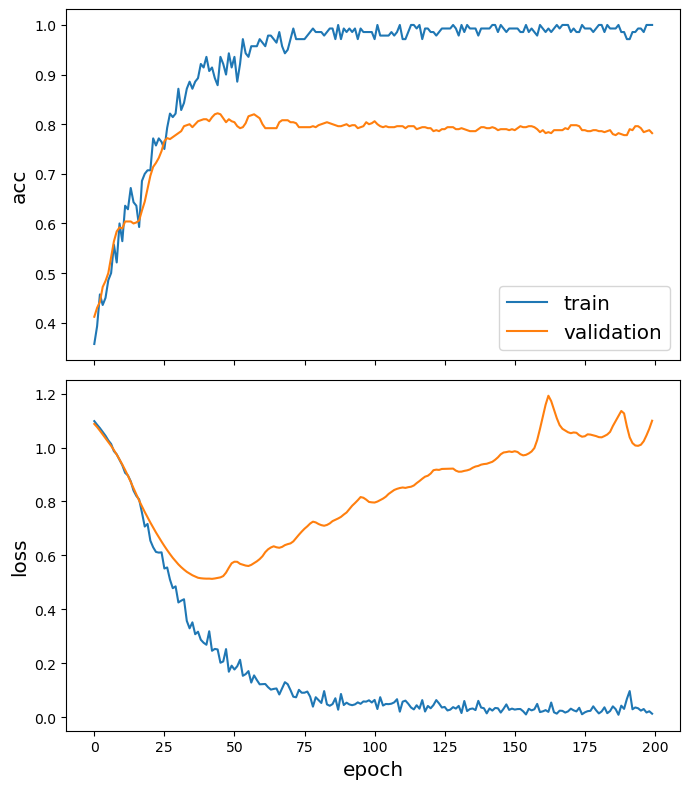

In [22]:
sg.utils.plot_history(history)

In [23]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [24]:

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))



1/1 [==============================] - 0s 116ms/step - loss: 1.0452 - acc: 0.7875

Test Set Metrics:
	loss: 1.0452
	acc: 0.7875
